In [125]:
import pandas as pd
import matplotlib.pyplot as plt

In [128]:
# Fungsi untuk mengubah detik menjadi hari di bulan Mei 1957
def convert_seconds_to_days(row):
    second = row.second  # Ambil nilai detik dari timeStamps
    
    # Tentukan bulan dan tahun
    year = 1957
    month = 5

    # Hari ditentukan dari detik, jadi detik ke-10 = hari ke-15, dst.
    new_day = second + 5
    
    # Pastikan hari dalam rentang yang valid untuk bulan tersebut
    try:
        new_date = pd.Timestamp(year=year, month=month, day=new_day)
    except ValueError:
        # Jika hari tidak valid, gunakan tanggal terakhir bulan sebelumnya dan tambahkan bulan
        # Ubah bulan jika hari melebihi jumlah hari dalam bulan
        new_month = month + (new_day - 1) // 31
        new_day = (new_day - 1) % 31 + 1
        new_date = pd.Timestamp(year=year, month=new_month, day=new_day)
    
    # Kembalikan hanya tahun, bulan, dan hari
    return new_date.strftime('%Y-%m-%d')

In [129]:
df = pd.read_csv("./dataset_fixeds.csv")


def set_milliseconds_to_683(timestamp):
    return timestamp.replace(microsecond=683000)  # 683 ms = 683000 µs


df['timeStamps'] = pd.to_datetime(df['timeStamps'], utc=True)


df['converted_time'] = df['timeStamps'].apply(convert_seconds_to_days)

df

ValueError: day is out of range for month

In [107]:
import pandas as pd

# Contoh DataFrame dengan timeStamps sebagai kolom
data = {'timeStamps': ['2024-09-16 06:11:11', '2024-09-16 06:11:12', '2024-09-16 06:11:13']}
df = pd.DataFrame(data)

# Konversi kolom timeStamps menjadi datetime
df['timeStamps'] = pd.to_datetime(df['timeStamps'])



# Terapkan fungsi ke kolom timeStamps
df['converted_time'] = df['timeStamps'].apply(convert_seconds_to_days)

# Tampilkan DataFrame hasil
print(df[['timeStamps', 'converted_time']])

           timeStamps converted_time
0 2024-09-16 06:11:11     1957-05-16
1 2024-09-16 06:11:12     1957-05-17
2 2024-09-16 06:11:13     1957-05-18


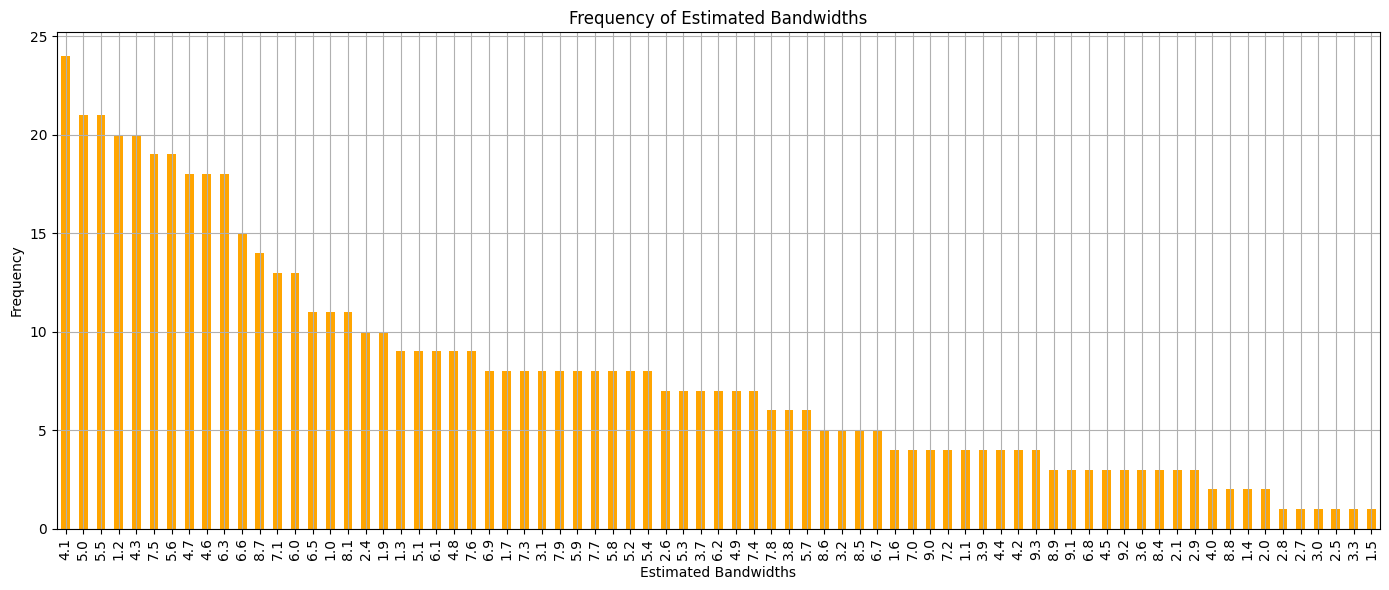

In [55]:


frequency = df['estimatedBandwidths'].value_counts()
# print(frequency)
frequency
plt.figure(figsize=(14, 6))

# Plot resampled data
# plt.subplot(1, 2, 1)
# plt.plot(resampled_data.index, resampled_data.values, marker='o', color='b')
# plt.title('Resampled Data (5 Minutes Count)')
# plt.xlabel('Time')
# plt.ylabel('Count')
# plt.grid()


# Plot frequency
frequency.plot(kind='bar', color='orange')
plt.title('Frequency of Estimated Bandwidths')
plt.xlabel('Estimated Bandwidths')
plt.ylabel('Frequency')
plt.grid()

plt.tight_layout()
plt.show()


In [72]:
y = df['estimatedBandwidths']

# Tentukan index untuk split data (70% untuk training, 30% untuk testing)
split_index = int(len(y) * 0.8)

# Split data ke training dan testing set
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]
y_train


timeStamps
2024-09-16 06:11:10.683000+00:00    3.1
2024-09-16 06:11:11.683000+00:00    7.1
2024-09-16 06:11:12.683000+00:00    7.1
2024-09-16 06:11:13.683000+00:00    7.1
2024-09-16 06:11:14.683000+00:00    7.1
                                   ... 
2024-09-16 06:22:46.683000+00:00    8.1
2024-09-16 06:22:47.683000+00:00    8.1
2024-09-16 06:22:50.683000+00:00    8.1
2024-09-16 06:22:51.683000+00:00    8.1
2024-09-16 06:22:52.683000+00:00    8.1
Name: estimatedBandwidths, Length: 470, dtype: float64

In [67]:
# Cek stasioneritas untuk y_train
from statsmodels.tsa.stattools import adfuller

result_train = adfuller(y_train)
print('ADF Statistic (Train):', result_train[0])
print('p-value (Train):', result_train[1])

if result_train[1] > 0.05:
    print("y_train belum stasioner, kita perlu differencing.")
    y_train_diff = y_train.diff().dropna()  # Apply differencing buat bikin stasioner
else:
    print("y_train udah stasioner.")
    y_train_diff = y_train


ADF Statistic (Train): -3.706807292702358
p-value (Train): 0.004018415981795536
y_train udah stasioner.


In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Latih model SARIMAX
model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 60))
results = model.fit()
# # Lihat ringkasan hasil model
# print(results.summary())
# Prediksi mulai dari titik di mana data uji dimulai hingga akhir data uji


# # Forecast ke depan
# forecast = results.get_forecast(steps=60)  # Misalnya, prediksi 60 detik ke depan
# print(forecast.predicted_mean)

d:\cursor_code\python\Lstm\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\cursor_code\python\Lstm\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [98]:
start = len(y_train)
end = len(y) - 1

# Prediksi untuk periode yang sama dengan data uji
y_pred = results.predict(start=start, end=end, dynamic=False)
y_pred

d:\cursor_code\python\Lstm\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\cursor_code\python\Lstm\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


470    8.199852
471    8.306833
472    8.371483
473    8.188950
474    8.491771
         ...   
583    8.927065
584    9.161955
585    9.148476
586    8.990500
587    8.934207
Name: predicted_mean, Length: 118, dtype: float64

In [105]:
y_pred.shape
y_train.shape


(470,)

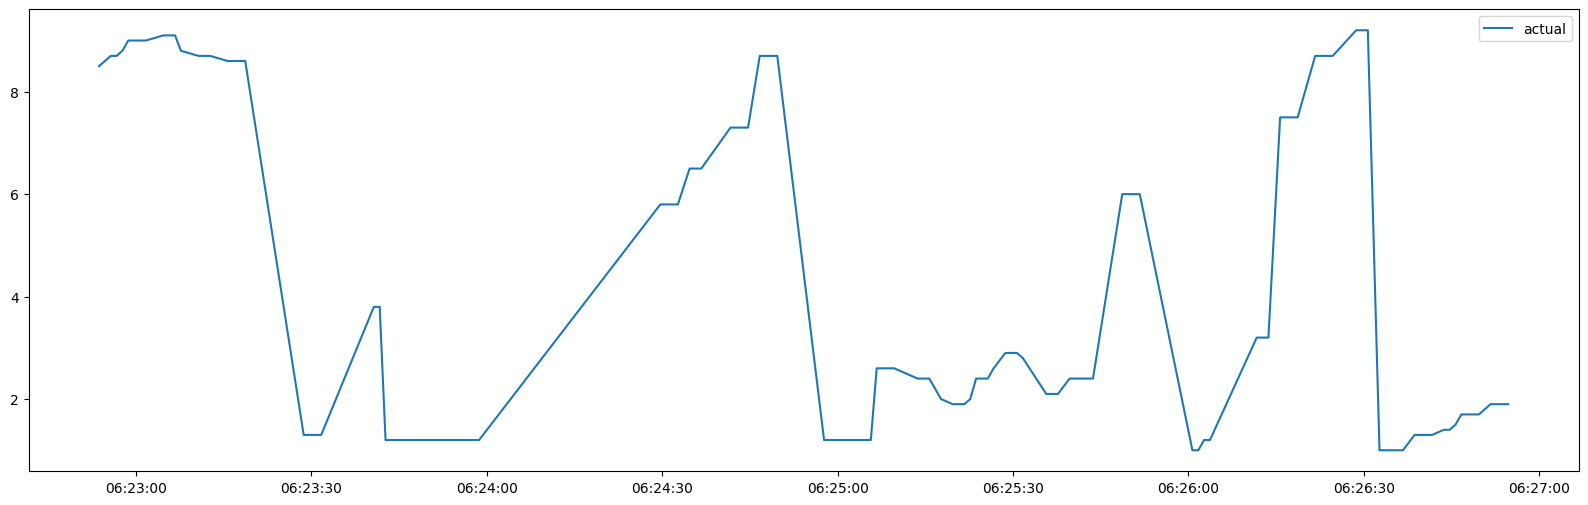

In [86]:
plt.figure(figsize=(20, 6))
plt.plot(y_test , label='actual')
# plt.plot(y_pred , label='Predicted')
plt.legend()
plt.show()

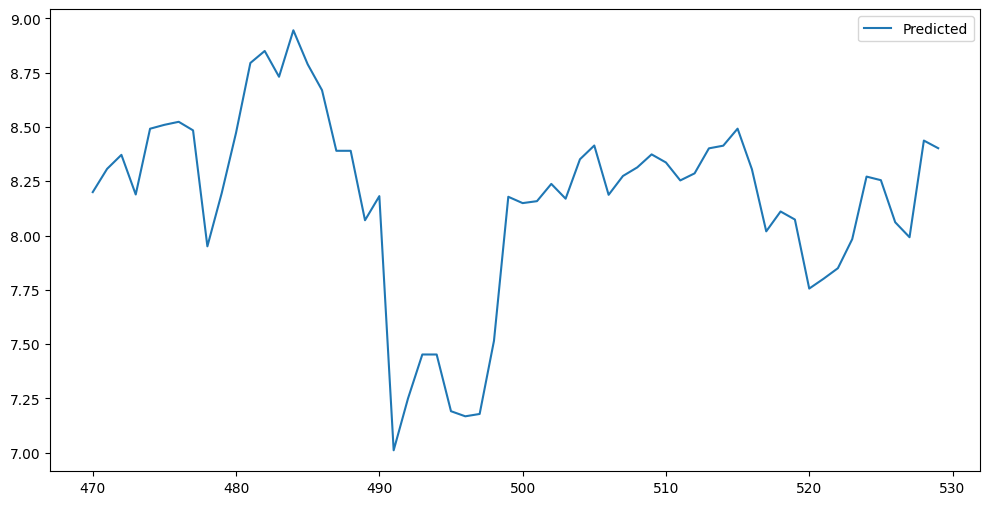

In [80]:
plt.figure(figsize=(12, 6))
# plt.plot(y_test , label='Predicted')
plt.plot(forecast.predicted_mean , label='Predicted')
plt.legend()
plt.show()

In [71]:
from sklearn.metrics import r2_score

r2 = r2_score(predictions,y_test)
r2

-886.7458884585741

In [130]:
import pandas as pd

# Contoh DataFrame dengan timeStamps termasuk milidetik dan zona waktu
data = {'timeStamps': ['2024-09-16 06:11:10.683000+00:00', '2024-09-16 06:11:11.824000+00:00', '2024-09-16 06:11:12.000000+00:00']}
df = pd.DataFrame(data)

# Konversi kolom timeStamps menjadi datetime
df['timeStamps'] = pd.to_datetime(df['timeStamps'], utc=True)

# Fungsi untuk mengubah detik menjadi hari di bulan Mei 1957, dengan penyesuaian jika hari tidak valid
def convert_seconds_to_days(row):
    second = row.second  # Ambil nilai detik dari timeStamps
    
    # Tentukan bulan dan tahun
    year = 1957
    month = 5

    # Hari ditentukan dari detik, jadi detik ke-10 = hari ke-15, dst.
    new_day = second + 5
    
    # Pastikan hari dalam rentang yang valid untuk bulan tersebut
    try:
        new_date = pd.Timestamp(year=year, month=month, day=new_day)
    except ValueError:
        # Jika hari tidak valid, gunakan tanggal terakhir bulan sebelumnya dan tambahkan bulan
        # Ubah bulan jika hari melebihi jumlah hari dalam bulan
        new_month = month + (new_day - 1) // 31
        new_day = (new_day - 1) % 31 + 1
        new_date = pd.Timestamp(year=year, month=new_month, day=new_day)
    
    # Kembalikan hanya tahun, bulan, dan hari
    return new_date.strftime('%Y-%m-%d')

# Terapkan fungsi ke kolom timeStamps
df['converted_time'] = df['timeStamps'].apply(convert_seconds_to_days)

# Tampilkan DataFrame hasil
print(df[['timeStamps', 'converted_time']])


                        timeStamps converted_time
0 2024-09-16 06:11:10.683000+00:00     1957-05-15
1 2024-09-16 06:11:11.824000+00:00     1957-05-16
2        2024-09-16 06:11:12+00:00     1957-05-17
